# Chapter 2 Denoising and Detoning

reduce the noise and enhance the signal included in an empirical covariance matrix.

In [59]:
import numpy as np,pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## The Marcenko-Pastur Theorem


### SNIPPET 2.1

In [60]:

#--------------------------------------------------- 

def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N 
    # when var= 1, C = T^-1 X'X  is the correlation matrix associated with X
    # lambda+ =,lambda- = eMax, eMin
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2 
    eVal=np.linspace(eMin,eMax,pts) 
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 
    #pdf = pdf.ravel()
    pdf=pd.Series(pdf,index=eVal)
    return pdf


### SNIPPET 2.2

In [61]:
from sklearn.neighbors.kde import KernelDensity
#--------------------------------------------------- 
def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix 
    eVal,eVec=np.linalg.eigh(matrix) 
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc 
    eVal,eVec=eVal[indices],eVec[:,indices] 
    eVal=np.diagflat(eVal)
    return eVal,eVec 
#--------------------------------------------------- 
def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated 
    if len(obs.shape)==1:
        obs=obs.reshape(-1,1) 
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs) 
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:
        x=x.reshape(-1,1) 
    logProb=kde.score_samples(x) # log(density) 
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf


Text(0.5, 0, '$\\lambda$')

Text(0, 0.5, 'prob[$\\lambda$]')

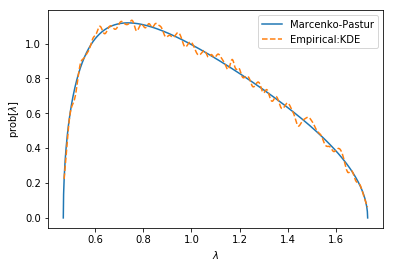

In [62]:
#--------------------------------------------------- 
x=np.random.normal(size=(10000,1000)) 
eVal0,eVec0=getPCA(np.corrcoef(x,rowvar=False)) # each column is a variable
pdf0=mpPDF(1.,q=x.shape[0]/float(x.shape[1]),pts=1000) 
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf
ax = plt.figure().add_subplot(111)
ax.plot(pdf0,label= 'Marcenko-Pastur')
ax.plot(pdf1,linestyle = '--',label= 'Empirical:KDE')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'prob[$\lambda$]')
ax.legend()

## Random Matrix with Signal (not perfectly random)

In [63]:
#SNIPPET 2.3 ADD SIGNAL TO A RANDOM COVARIANCE MATRIX
def getRndCov(nCols,nFacts): 
    w=np.random.normal(size=(nCols,nFacts))
    cov=np.dot(w,w.T) # random cov matrix, however not full rank 
    cov+=np.diag(np.random.uniform(size=nCols)) # full rank cov 
    return cov
#--------------------------------------------------- 
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov)) 
    corr=cov/np.outer(std,std) 
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error 
    return corr
#--------------------------------------------------- 
alpha,nCols,nFact,q=.995,1000,100,10 
cov=np.cov(np.random.normal(size=(nCols*q,nCols)),rowvar=False) 
cov=alpha*cov+(1-alpha)*getRndCov(nCols,nFact) # noise+signal 
corr0=cov2corr(cov)
eVal0,eVec0=getPCA(corr0)

In [64]:
#SNIPPET 2.4 FITTING THE MARCENKO–PASTUR PDF 
from scipy.optimize import minimize
#--------------------------------------------------- 
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    var = var[0]
    pdf0=mpPDF(var,q,pts) # theoretical pdf 
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf 
    #import pdb; pdb.set_trace()
    sse=np.sum((pdf1-pdf0)**2)
    return sse
#--------------------------------------------------- 
def findMaxEval(eVal,q,bWidth):
# Find max random eVal by fitting Marcenko’s dist 
    out=minimize(lambda *x: errPDFs(*x),.5,args=(eVal,q,bWidth),bounds=((1E-5,1-1E-5),))
    if out['success']:
        var=out['x'][0] 
    else:
        var=1 
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var
#--------------------------------------------------- 
eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth=.01) 
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

# nFacts0 gives the number of the eigenvalue is assumed to be important (cutoff level lambda+ adjusted for the presence of nonrandom eigenvectors)

<BarContainer object of 1000 artists>

Text(0.5, 0, '$\\lambda$')

Text(0, 0.5, 'prob[$\\lambda$]')

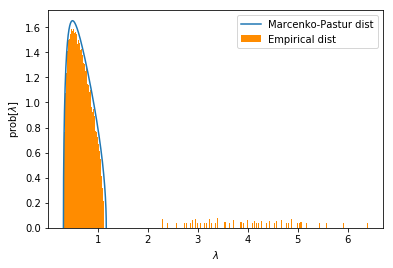

In [65]:
#---------------------------------------------------
# Fitting the Marcenko–Pastur PDF on a noisy covariance matrix.
# estimate the sigma for Marcenko-Pastur dist
bWidth=0.01
out=minimize(lambda *x: errPDFs(*x),.5,args=(np.diag(eVal0),q,bWidth),bounds=((1E-5,1-1E-5),))
if out['success']:
    var=out['x'][0] 
else:
    var=1

pdf0=mpPDF(var,q,pts=1000) # Marcenko-Pastur dist
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf
ax = plt.figure().add_subplot(111)
ax.plot(pdf0,label= 'Marcenko-Pastur dist')
ax.bar(pdf1.index,pdf1.values,width = bWidth,label= 'Empirical dist',color = 'darkorange')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'prob[$\lambda$]')
ax.legend()

## 2.5 Denoising

### 2.5.1 Constant Residual Eigenvalue Method

setting a constant eigenvalue for all random eigenvectors.

In [66]:
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues 
    eVal_=np.diag(eVal).copy() 
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts) # average the rest
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T) 
    corr1=cov2corr(corr1)
    return corr1
#--------------------------------------------------- 
corr1=denoisedCorr(eVal0,eVec0,nFacts0) 
eVal1,eVec1=getPCA(corr1)

Text(0.5, 0, 'Eigenvalue number')

Text(0, 0.5, 'Eigenvalue (log-scale)')

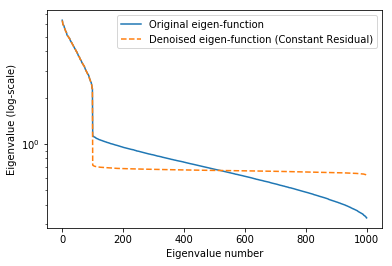

In [67]:
# A comparison of eigenvalues before and after applying the residual eigenvalue method.
ax = plt.figure().add_subplot(111)
ax.plot(np.diagonal(eVal0),label = 'Original eigen-function')
ax.plot(np.diagonal(eVal1),label = 'Denoised eigen-function (Constant Residual)',linestyle = '--')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number')
ax.set_ylabel('Eigenvalue (log-scale)')

### 2.5.2 Targeted Shrinkage
$\alpha$ regulates the amount fo shrinkage among the eigen vectors

In [68]:
#SNIPPET 2.6 DENOISING BY TARGETED SHRINKAGE
def denoisedCorr2(eVal,eVec,nFacts,alpha=0):
# Remove noise from corr through targeted shrinkage
    eValL,eVecL=eVal[:nFacts,:nFacts],eVec[:,:nFacts] 
    eValR,eVecR=eVal[nFacts:,nFacts:],eVec[:,nFacts:] 
    corr0=np.dot(eVecL,eValL).dot(eVecL.T) 
    corr1=np.dot(eVecR,eValR).dot(eVecR.T) 
    corr2=corr0+alpha*corr1+(1-alpha)*np.diag(np.diag(corr1)) 
    return corr2
#--------------------------------------------------- 
corr1=denoisedCorr2(eVal0,eVec0,nFacts0,alpha=.5) 
eVal1,eVec1=getPCA(corr1)

Text(0.5, 0, 'Eigenvalue number')

Text(0, 0.5, 'Eigenvalue (log-scale)')

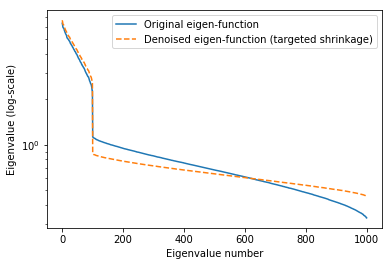

In [69]:
# A comparison of eigenvalues before and after applying the residual eigenvalue method.
ax = plt.figure().add_subplot(111)
ax.plot(np.diagonal(eVal0),label = 'Original eigen-function')
ax.plot(np.diagonal(eVal1),label = 'Denoised eigen-function (targeted shrinkage)',linestyle = '--')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number')
ax.set_ylabel('Eigenvalue (log-scale)')

# Experimental Results
## 2.7.1 Minimum Variance Portfolio

In [70]:
def corr2cov(corr,std):
    # Derive the covariance matrix from a correlation matrix
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error 
    cov = np.outer(std,std)*corr
    return cov

In [71]:

#SNIPPET 2.7 GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS
def formBlockMatrix(nBlocks,bSize,bCorr): 
    block=np.ones((bSize,bSize))*bCorr 
    block[range(bSize),range(bSize)]=1 
    corr=block_diag(*([block]*nBlocks)) 
    return corr
#--------------------------------------------------- 
def formTrueMatrix(nBlocks,bSize,bCorr):
    #In each block, the variances are drawn from a uniform distribution bounded between 5% and 20%; the vector of means is drawn from a Normal distribution with mean and standard deviation equal to the standard deviation from the covariance matrix
    corr0=formBlockMatrix(nBlocks,bSize,bCorr) 
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols) 
    corr0=corr0[cols].loc[cols].copy(deep=True) 
    std0=np.random.uniform(.05,.2,corr0.shape[0]) 
    cov0=corr2cov(corr0,std0) 
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1) 
    return mu0,cov0
#--------------------------------------------------- 
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf 
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

In [72]:
#SNIPPET 2.8 GENERATING THE EMPIRICAL COVARIANCE MATRIX
def simCovMu(mu0,cov0,nObs,shrink=False): 
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs) 
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:
        cov1=LedoitWolf().fit(x).covariance_ 
    else:
        cov1=np.cov(x,rowvar=0)
    return mu1,cov1

In [73]:
# SNIPPET 2.9 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0) 
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth) 
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0) 
    corr1=denoisedCorr(eVal0,eVec0,nFacts0) 
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

In [82]:
#SNIPPET 2.10 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
def optPort(cov,mu=None): # optimal portfolio for minimum variance
    inv=np.linalg.inv(cov) 
    ones=np.ones(shape=(inv.shape[0],1)) 
    if mu is None:
        mu=ones
    w=np.dot(inv,mu) 
    w/=np.dot(ones.T,w) 
    return w
#--------------------------------------------------- 
nObs,nTrials,bWidth,shrink,minVarPortf=1000,100,.01,False,True 
w1= w1_s=pd.DataFrame(columns=range(cov0.shape[0]),
index=range(nTrials),dtype=float) 
w1_d=w1.copy(deep=True)
w1_s_d = w1_s.copy(deep = True)
np.random.seed(0)
for i in tqdm(range(nTrials)):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=True)
    if minVarPortf:
        mu1=None 
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth) 
    w1_s.loc[i]=optPort(cov1,mu1).flatten() 
    w1_s_d.loc[i]=optPort(cov1_d,mu1).flatten()
    
    
for i in tqdm(range(nTrials)):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=False)
    if minVarPortf:
        mu1=None 
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth) 
    w1.loc[i]=optPort(cov1,mu1).flatten() 
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()

In [92]:
#SNIPPET 2.11 ROOT-MEAN-SQUARE ERRORS
w0=optPort(cov0,None if minVarPortf else mu0) 
w0=np.repeat(w0.T,w1.shape[0],axis=0) 
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE  not shrunk not denoised
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE not shrunk denoised
rmsd_s=np.mean((w1_s-w0).values.flatten()**2)**.5 # RMSE shrunk not denoised
rmsd_s_d=np.mean((w1_s_d-w0).values.flatten()**2)**.5 # RMSE shrunk denoised

res_tab = pd.DataFrame(columns = ['Note denoised','Denoised'],index = ['Not shrunk','Shrunk'],data = np.array([[rmsd,rmsd_d],[rmsd_s,rmsd_s_d]]))
res_tab

,Note denoised,Denoised
Not shrunk,0.004929,0.001138
Shrunk,0.004929,0.001369
